In [1]:
try:
    import jax
except ModuleNotFoundError:
    %pip install jaxlib jax
    import jax
import jax.numpy as jnp

try:
    import tensorflow_probability.substrates.jax as tfp
except ModuleNotFoundError:
    %pip install tensorflow-probability
    import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions

try:
    import numpyro
except ModuleNotFoundError:
    %pip install numpyro
    import numpyro

import numpyro.distributions as dist
import numpyro.distributions.constraints as constraints

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from sklearn.datasets import load_diabetes
from sklearn.preprocessing import StandardScaler

# Fix the data

(442, 3)


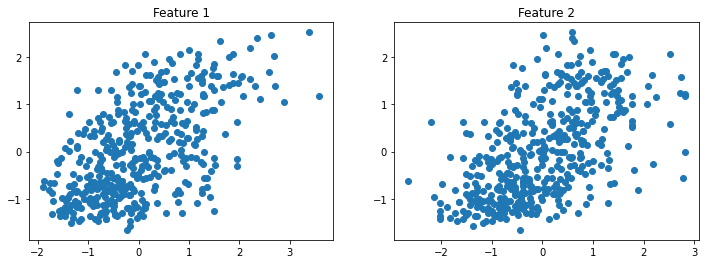

In [2]:
X, y = load_diabetes(return_X_y=True)

# Use only two features
X = X[:, [2, 8]]

# Add bias to X
X = jnp.hstack((jnp.ones((X.shape[0], 1)), X))
print(X.shape)

# scale data
X = StandardScaler().fit_transform(X)
y = StandardScaler().fit_transform(y.reshape(-1,1)).reshape(-1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
ax1.scatter(X[:, 1], y)
ax1.set_title('Feature 1')
ax2.scatter(X[:, 2], y)
ax2.set_title('Feature 2');

# Graphical model

In [3]:
def model(m_0, S_0, X, y, noise_variance):
    m_0 = numpyro.param("m_0", m_0, constraint=constraints.real)
    S_0 = numpyro.param("S_0", S_0, constraint=constraints.positive_definite)
    theta = numpyro.sample("theta", dist.MultivariateNormal(loc=m_0, covariance_matrix=S_0))
    noise_variance = numpyro.param("sigma_sqr", noise_variance, constraint=constraints.positive)
    loc = jnp.dot(X, theta)
    y_obs = numpyro.sample("y", dist.MultivariateNormal(loc=loc, covariance_matrix=jnp.eye(num_examples)*noise_variance), obs=y)

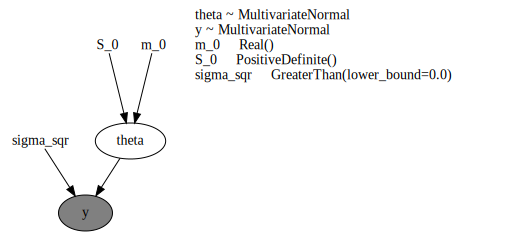

In [4]:
num_examples = X.shape[0]
num_features = X.shape[1]

m_0 = jnp.zeros(num_features)
S_0 = jnp.eye(num_features)
noise_variance = 0.01

model_args = (m_0, S_0, X, y, noise_variance)
numpyro.render_model(model, model_args, render_distributions=True, render_params=True)

# Sample from prior predictive distribution

## Monte carlo sampling
1. Draw a sample ($\theta$) from prior: $p(\boldsymbol{\theta}) = \mathcal{N}(\boldsymbol{m}_0, S_0)$
2. Draw a sample ($\boldsymbol{y}$) using $\boldsymbol{\theta}$ from step 1: $p(\boldsymbol{y}) = \mathcal{N}(X\boldsymbol{\theta}, \sigma^2I)$
3. Repeat step 1 and 2 $N$ times with different seeds to get $N$ samples from prior predictive distribution

In [5]:
def sample_prior(seed):
    prior = tfd.MultivariateNormalFullCovariance(loc=m_0, covariance_matrix=S_0)
    return prior.sample(seed=seed)

def sample_likelihood(seed, theta, X, noise_variance):
    def sample_one_likelihood(seed, x):
        likelihood = tfd.Normal(loc=(x*theta).sum(), scale=noise_variance)
        return likelihood.sample(seed=seed)
    
    seeds = jax.random.split(seed, num=X.shape[0])
    sample = jax.vmap(sample_one_likelihood)(seeds, X)
    return sample

def sample_monte_carlo(seed, X, noise_variance, num_samples):
    def sample_one_monte_carlo(seed, X, noise_variance):
        theta = sample_prior(seed=seed)
        seed = jax.random.split(seed, num=1)[0]
        sample = sample_likelihood(seed, theta, X, noise_variance)
        return sample
    
    seeds = jax.random.split(seed, num=num_samples)
    sample_fun = jax.jit(jax.vmap(sample_one_monte_carlo, in_axes=(0, None, None)))
    return sample_fun(seeds, X, noise_variance)

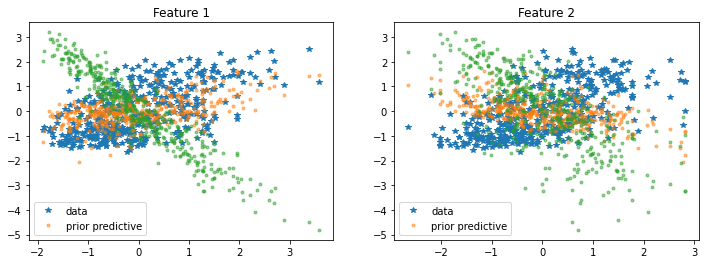

In [6]:
seed = jax.random.PRNGKey(0)

y_samples = sample_monte_carlo(seed, X, noise_variance, num_samples=2)

def plot_samples(X, y, y_samples):
    fig, axes = plt.subplots(1, X.shape[1]-1, figsize=(12,4))
    for i, ax in enumerate(axes, start=1):
        ax.plot(X[:, i], y, '*', label='data')
        ax.plot(X[:, i], y_samples.T, '.', alpha=0.5)

        ax.legend(['data', 'prior predictive'])
        ax.set_title(f'Feature {i}')

plot_samples(X, y, y_samples)

## Sampling from marginal likelihood (integrated over theta)

\begin{align}
p(\boldsymbol{y}|X) &= \int p(\boldsymbol{y}|X, \boldsymbol{\theta})p(\boldsymbol{\theta})d\boldsymbol{\theta}\\
&= \int \mathcal{N}(X\boldsymbol{\theta}, \sigma^2I)\mathcal{N}(\boldsymbol{m}_0, S_0)d\boldsymbol{\theta}\\
&= \mathcal{N}(X\boldsymbol{m}_0, XS_0X^T + \sigma^2I)
\end{align}

Derivation of the above formula follows from 2.113, 2.114 and 2.115 of [PRML book by Bishop](https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf).

In [7]:
def get_predictive(theta_distribution, X, noise_variance):
    theta_loc = theta_distribution.mean()
    theta_cov = theta_distribution.covariance()
    loc = X@theta_loc
    cov = X@theta_cov@X.T + jnp.eye(X.shape[0])*noise_variance
    return tfd.MultivariateNormalFullCovariance(loc=loc, covariance_matrix=cov)

def sample_predictive(seed, theta_distribution, X, noise_variance, num_samples=1):
    predictive = get_predictive(theta_distribution, X, noise_variance)
    samples = predictive.sample(seed=seed, sample_shape=(num_samples,))
    return samples

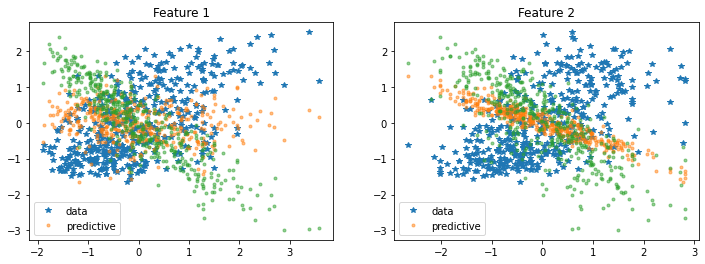

In [8]:
seed = jax.random.PRNGKey(2)

prior = tfd.MultivariateNormalFullCovariance(loc=m_0, covariance_matrix=S_0)
y_samples = sample_predictive(seed, prior, X, noise_variance, num_samples=2)

def plot_samples(X, y, y_samples):
    fig, axes = plt.subplots(1, X.shape[1]-1, figsize=(12,4))
    for i, ax in enumerate(axes, start=1):
        ax.plot(X[:, i], y, '*', label='data')
        ax.plot(X[:, i], y_samples.T, '.', alpha=0.5)

        ax.legend(['data', 'predictive'])
        ax.set_title(f'Feature {i}')

plot_samples(X, y, y_samples)

### Plot 95% confidence interval

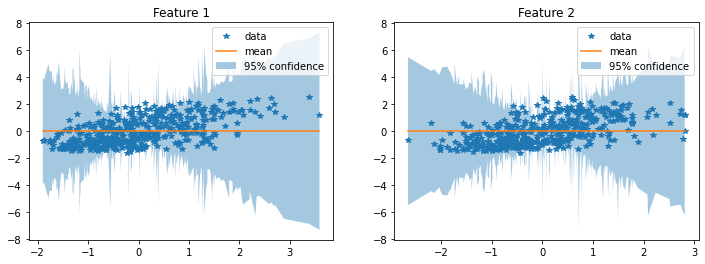

In [9]:
def plot_interval(X, y, predictive_dist):
    loc = predictive_dist.loc
    variance = predictive_dist.variance()
    scale = variance**0.5
    fig, axes = plt.subplots(1, X.shape[1]-1, figsize=(12,4))
    for i, ax in enumerate(axes, start=1):
        idx = jnp.argsort(X[:, i])
        ax.plot(X[idx, i], y[idx], '*', label='data')
        ax.plot(X[idx, i], loc[idx], label='mean')
        ax.fill_between(X[idx, i], loc[idx]-2*scale[idx], loc[idx]+2*scale[idx], alpha=0.4, label='95% confidence')
        ax.legend()
        ax.set_title(f'Feature {i}')

prior_predictive = get_predictive(prior, X, noise_variance)
plot_interval(X, y, predictive_dist=prior_predictive)

## Which method is better?

In [10]:
seed = jax.random.PRNGKey(12)
num_samples = 1000

ground_truth_distribuion = get_predictive(prior, X, noise_variance)

def get_kl_divergence(samples):
    loc = samples.mean(axis=0)
    cov = jnp.cov(samples.T)

    empirical_distribution = tfd.MultivariateNormalFullCovariance(loc=loc, covariance_matrix=cov)

    return tfd.kl_divergence(ground_truth_distribuion, empirical_distribution)

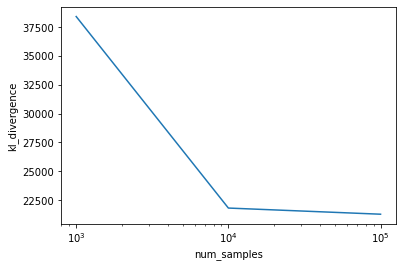

In [11]:
num_samples_list = [10**3, 10**4, 10**5]
kl_divergence_list = []
for num_samples in num_samples_list:
    monte_carlo_samples = sample_monte_carlo(seed, X, noise_variance, num_samples=num_samples)
    kl_divergence_list.append(get_kl_divergence(monte_carlo_samples))

plt.plot(num_samples_list, kl_divergence_list)
plt.xscale('log')
plt.xlabel('num_samples');
plt.ylabel('kl_divergence');

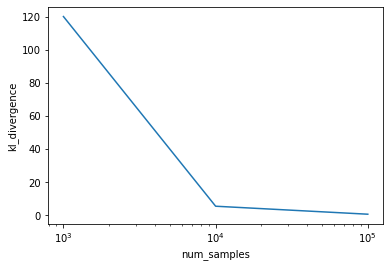

In [12]:
marginal_lik_samples = sample_predictive(seed, prior, X, noise_variance, num_samples=num_samples)
num_samples_list = [10**3, 10**4, 10**5]
kl_divergence_list = []
for num_samples in num_samples_list:
    marginal_lik_samples = sample_predictive(seed, prior, X, noise_variance, num_samples=num_samples)
    kl_divergence_list.append(get_kl_divergence(marginal_lik_samples))

plt.plot(num_samples_list, kl_divergence_list)
plt.xscale('log')
plt.xlabel('num_samples');
plt.ylabel('kl_divergence');

We can see that sampling directly from the marginal distribution is a lot better than monte carlo sampling based on kl_divergence.

## Sampling from posterior predictive distribution

We will use closed form formulas from Maths for ML book (Eq. 9.43).

\begin{aligned}
p(\boldsymbol{\theta} \mid \mathcal{X}, \mathcal{Y}) &=\mathcal{N}\left(\boldsymbol{\theta} \mid \boldsymbol{m}_{N}, \boldsymbol{S}_{N}\right) \\
\boldsymbol{S}_{N} &=\left(\boldsymbol{S}_{0}^{-1}+\sigma^{-2} \boldsymbol{\Phi}^{\top} \boldsymbol{\Phi}\right)^{-1} \\
\boldsymbol{m}_{N} &=\boldsymbol{S}_{N}\left(\boldsymbol{S}_{0}^{-1} \boldsymbol{m}_{0}+\sigma^{-2} \boldsymbol{\Phi}^{\top} \boldsymbol{y}\right)
\end{aligned}

In [13]:
S_0_inv = jnp.linalg.inv(S_0)
S_n_inv =  S_0_inv + (X.T@X)/noise_variance
S_n = jnp.linalg.inv(S_n_inv)

m_n = S_n@(S_0_inv@m_0 + (X.T@y)/noise_variance)

posterior = tfd.MultivariateNormalFullCovariance(loc=m_n, covariance_matrix=S_n)

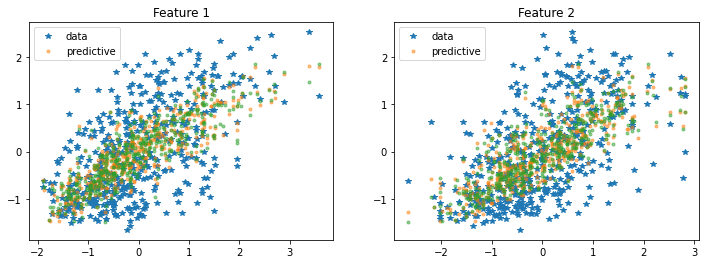

In [14]:
seed = jax.random.PRNGKey(2)

y_samples = sample_predictive(seed, posterior, X, noise_variance, num_samples=2)

plot_samples(X, y, y_samples)

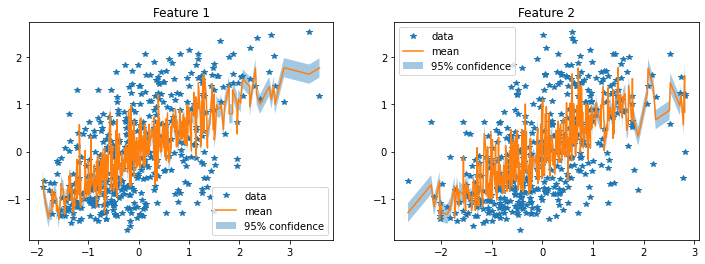

In [15]:
posterior_predictive = get_predictive(posterior, X, noise_variance)
plot_interval(X, y, predictive_dist=posterior_predictive)

### Plot contours

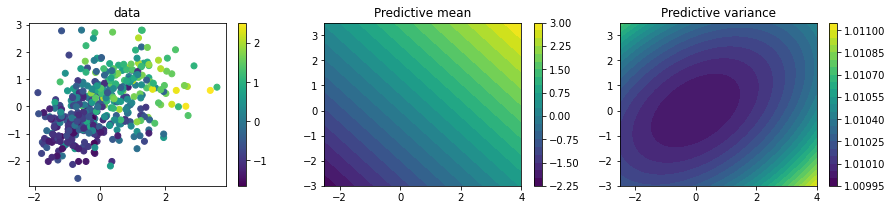

In [16]:
x1 = jnp.linspace(-2.5, 4, 100)
x2 = jnp.linspace(-3, 3.5, 100)

X1, X2 = jnp.meshgrid(x1, x2)
def get_mean(x1, x2):
    y_mean = m_n[0] + m_n[1] * x1 + m_n[2] * x2
    return y_mean

def get_variance(x1, x2):
    x = jnp.array([1.0, x1, x2]).reshape(1, -1)
    variance = x@S_n@x.T + noise_variance
    return variance.squeeze()

mean_grid = jax.vmap(jax.vmap(get_mean))(X1, X2)
var_grid = jax.vmap(jax.vmap(get_variance))(X1, X2)

fig, ax = plt.subplots(1, 3, figsize=(15,3))
mappable = ax[0].scatter(X[:, 1], X[:, 2], c=y);
fig.colorbar(mappable, ax=ax[0]);
ax[0].set_title('data')
mappable = ax[1].contourf(X1, X2, mean_grid, levels=20);
fig.colorbar(mappable, ax=ax[1]);
ax[1].set_title('Predictive mean');
mappable = ax[2].contourf(X1, X2, var_grid, levels=20);
fig.colorbar(mappable, ax=ax[2]);
ax[2].set_title('Predictive variance');